In [87]:
import pickle
import os

In [88]:
CIFAR_DIR = r"D:\Learning_ML\cifar-10-batches-py"


In [89]:
dirs = [
    "batches.meta",
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5",
    "test_batch"
]

In [90]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [91]:
all_data = [0, 1, 2, 3, 4, 5, 6]

In [92]:
for i, direc in zip(range(len(dirs)), dirs):
    all_data[i] = unpickle(os.path.join(CIFAR_DIR, direc))
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [93]:
print(batch_meta)

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [94]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [95]:
import matplotlib.pyplot as plt
import numpy as np

In [96]:
X = data_batch1[b"data"]
X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")

| Code                         | What it does                                               |
| ---------------------------- | ---------------------------------------------------------- |
| `data_batch1[b"data"]`       | Gets raw image data (shape: 10000×3072)                    |
| `.reshape(10000, 3, 32, 32)` | Reshapes each image to `[3, 32, 32]` (channel-first)       |
| `.transpose(0, 2, 3, 1)`     | Converts to `[32, 32, 3]` format (height, width, channels) |
| `.astype("uint8")`           | Converts to integer pixel format for visualization         |

In [97]:
X[0].max()

255

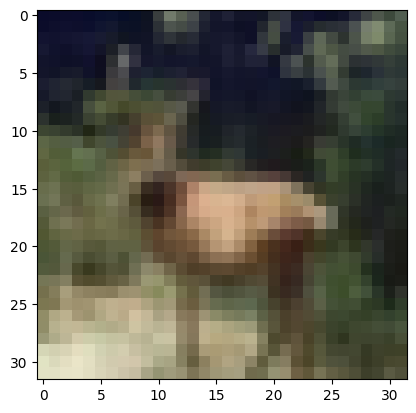

In [98]:
plt.imshow(X[856])

In [99]:
def one_hot_encode(vec, vals = 10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [100]:
class CIFAR_HELPER():
    def __init__(self):
        self.i = 0

        self.all_train_batches = [data_batch1, data_batch2, data_batch3, data_batch4, data_batch5]
        self.test_batch = [test_batch]

        self.training_image = None
        self.training_labels = None

        self.test_images = None
        self.test_label = None

    def set_up_images(self):
        print("Setting up Training images and labels")

        self.training_image = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_image)

        self.training_image = self.training_image.reshape(train_len, 3, 32, 32).transpose(0, 2, 3, 1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)

        print("SETTING UP Test images and labels")

        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len= len(self.test_images)

        self.test_images = self.test_images.reshape(test_len, 3, 32, 32).transpose(0, 2, 3, 1)/255
        self.test_label = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
    def next_batch(self, batch_size):
        x = self.training_image[self.i:self.i + batch_size]
        y = self.training_labels[self.i:self.i + batch_size]
        self.i = (self.i + batch_size) % len(self.training_image)
        return x, y


In [101]:
ch = CIFAR_HELPER()
ch.set_up_images()
# batch = ch.next_batch(100)

Setting up Training images and labels
SETTING UP Test images and labels


In [102]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_true = tf.placeholder(tf.float32, shape=[None, 10])
hold_prob = tf.placeholder(tf.float32)


In [103]:
import tensorflow as tf

def init_weights(shape):
    init_random_dist = tf.random.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b



1) def init_weights(shape):
Initializes a weight tensor of given shape.

Uses a truncated normal distribution to avoid large values (mean = 0, stddev = 0.1).

tf.Variable(...) makes the tensor trainable.

2) def init_bias(shape):
Initializes bias with constant values (0.1).

Helps ensure ReLU neurons are active initially (not dead).

3) def conv2d(x, W):
Applies a 2D convolution on input x using weights W.

strides=[1, 1, 1, 1]: move one pixel at a time.

'SAME' padding preserves the input dimensions.

4) def max_pool_2by2(x):
Applies 2x2 max pooling to reduce the spatial size.

ksize is the window size, and strides defines how far the window moves.

Reduces feature map size by half (with padding).

5) def convolutional_layer(input_x, shape):
Creates a complete convolutional layer:

Initializes weights and biases.

Applies convolution.

Adds bias.

Applies ReLU activation for non-linearity.

6) def normal_full_layer(input_layer, size):
Defines a fully connected (dense) layer.

input_layer.get_shape()[1] gets the number of features going in.

Applies matmul for a dense layer (dot product + bias).



In [104]:
conv_1 = convolutional_layer(x, shape=[4, 4, 3, 32])
conv_1_pooling = max_pool_2by2(conv_1)

conv_2 = convolutional_layer(conv_1_pooling, shape=[4, 4, 32, 64])
conv_2_pooling = max_pool_2by2(conv_2)


In [105]:
conv_2_flatten = tf.reshape(conv_2_pooling, [-1,8*8*64])

tf.reshape(...): reshapes the tensor.

-1: means TensorFlow will automatically calculate the batch size.

8*8*64: assumes the spatial dimensions are 8×8 with 64 channels (features).

In [106]:
full_layer_one = tf.nn.relu(normal_full_layer(conv_2_flatten, 1024))

In [108]:
dropout = tf.nn.dropout(full_layer_one, rate=1 - hold_prob)


In [125]:
y_pred = normal_full_layer(dropout, 10)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [126]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
train = optimizer.minimize(cross_entropy)

In [127]:
init = tf.global_variables_initializer()

In [130]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(500):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})

        if i % 100 == 0:
            print("Currently on step {}".format(i))
            matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            print("Accuracy:", sess.run(acc, feed_dict={x: ch.test_images, y_true: ch.test_label, hold_prob: 1.0}))
            print("\n")

    saver.save(sess, './cnn_cifar10_model.ckpt')


Currently on step 0
Accuracy: 0.1052


Currently on step 100
Accuracy: 0.4129


Currently on step 200
Accuracy: 0.4659


Currently on step 300
Accuracy: 0.5003


Currently on step 400
Accuracy: 0.5226


